#   Machine Learning Prediction Gold

In [19]:
#  %pip install quantstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.0 MB/s eta 0:00:00


In [2]:
# import libary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ForRunMLModel
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
# Calculate Evaluation Metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
#Reports
import quantstats as qs

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Install Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict Gold Price/XAU_1d_data.csv', sep=';')

df.columns = df.columns.str.lower()

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print(df.head())
print(f"Null:\n{df.isna().sum()}")


             open   high    low  close  volume
date                                          
2004-06-11  384.0  384.8  382.8  384.1     272
2004-06-14  384.3  385.8  381.8  382.8    1902
2004-06-15  382.8  388.8  381.1  388.6    1951
2004-06-16  387.1  389.8  382.6  383.8    2014
2004-06-17  383.6  389.3  383.0  387.6    1568
Null:
open      0
high      0
low       0
close     0
volume    0
dtype: int64


# 2. Data Processing

In [5]:
# Apply data processing steps before splitting

train_size = int(len(df) * 0.8)
train_data, test_data = df[0:train_size], df[train_size:]

print(f"Shape of training data: {train_data.shape}")
print(f"Shape of testing data: {test_data.shape}")

Shape of training data: (4334, 5)
Shape of testing data: (1084, 5)


In [6]:
# Select the 'close' price for training
train_close = train_data['close'].values.reshape(-1, 1)

# Scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_close)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Define sequence length (number of past days to consider)
seq_length = 60 # This can be tuned

X_train, y_train = create_sequences(scaled_train_data, seq_length)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (4274, 60, 1)
Shape of y_train: (4274,)


# 3. Model LSTM

In [7]:
# Define the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32)

# Store the trained model (optional, but good practice)
model.save('lstm_model.h5')

Epoch 1/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.0344
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.0022
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0017
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0016
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.0011
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 9.5987e-04
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 9.3935e-04
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 8.0620e-04
Epoch 9/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 7.0502e-04
Epoch 10/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 6.9982e-04
Epoch 11/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 7.1057e-04
Epoch 12/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 6.5376e-04
Epoch 13/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 6.1432e-04
Epoch 14/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 5.8129e-04

# 4. Predictions



In [9]:
# Prepare test data
# Select the 'close' price for testing
test_close = test_data['close'].values.reshape(-1, 1)

# Scale the test data using the *same* scaler fitted on the training data
scaled_test_data = scaler.transform(test_close)

# Create sequences for LSTM
# We need to include some data from the end of the training set to create the first test sequence
# A common approach is to combine the end of the training data with the test data
combined_data = scaled_train_data[len(scaled_train_data) - seq_length:]
combined_data = np.concatenate((combined_data, scaled_test_data))

X_test, y_test = create_sequences(combined_data, seq_length)

# Reshape input to be [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_test: (1084, 60, 1)
Shape of y_test: (1084,)


In [10]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get the actual price scale
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual test values for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Test Predictions (array):")
print(predictions)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Test Predictions (array):
[[1771.2911]
 [1772.8392]
 [1778.8922]
 ...
 [3221.988 ]
 [3226.6226]
 [3231.51  ]]


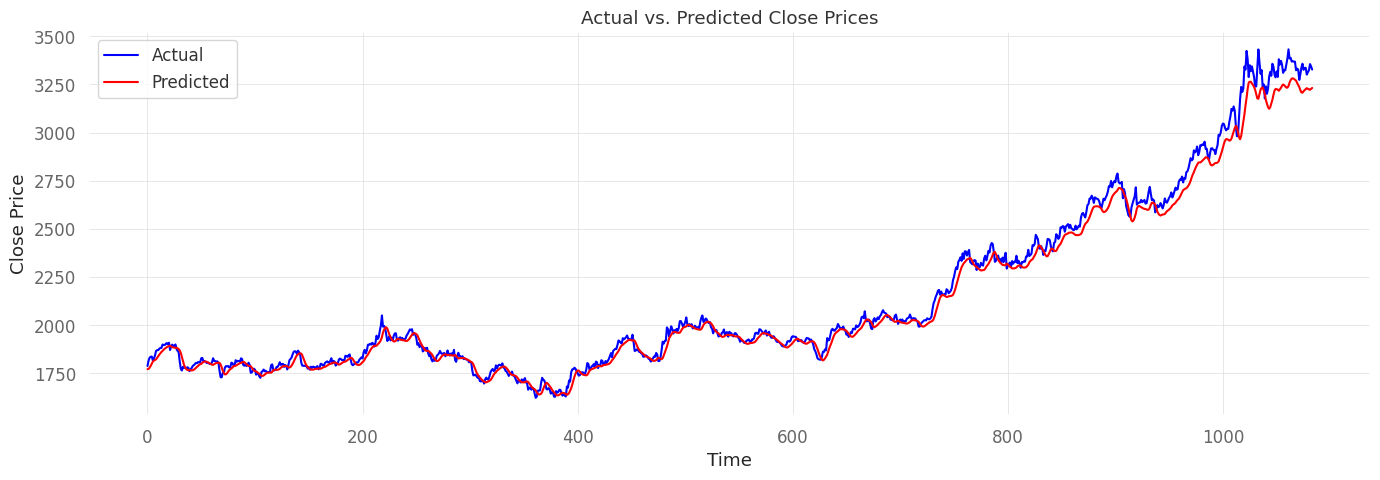

Mean Squared Error (MSE): 2434.9496
Root Mean Squared Error (RMSE): 49.3452


In [27]:
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, predictions)
rmse = sqrt(mse)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 5. Backtesting

## 5.1 Calculate Return

In [38]:
test_close_series = pd.Series(y_test_actual.flatten(), index=test_data.index)
predictions_series = pd.Series(predictions.flatten(), index=test_data.index)

# Calculate the previous day's prediction
previous_prediction = predictions_series.shift(1)

# Define the trading strategy signal:
# Go long (1)/ short (-1) if the current prediction is higher than/lower than the previous prediction
strategy_signal = np.where(predictions_series > previous_prediction, 1, -1)
strategy_signal = pd.Series(strategy_signal, index=test_data.index).fillna(0)

# Calculate Return
actual_daily_returns = test_close_series.pct_change().fillna(0)
strategy_daily_returns = strategy_signal * actual_daily_returns

#Calculate cumulative
cumulative_actual_returns = (1 + actual_daily_returns).cumprod() - 1
cumulative_strategy_returns = (1 + strategy_daily_returns).cumprod() - 1

## 5.2 Visualization strategy results



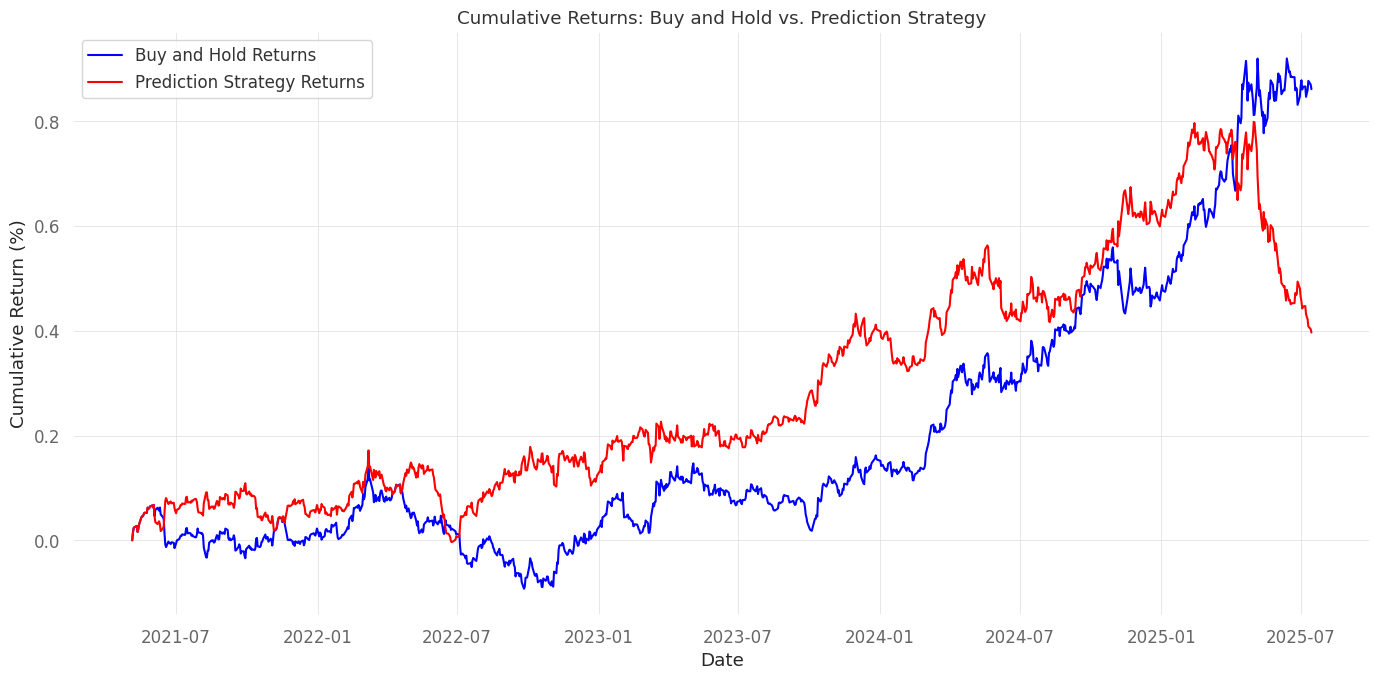

In [39]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1)

ax.plot(cumulative_actual_returns, label='Buy and Hold Returns', color='blue')
ax.plot(cumulative_strategy_returns, label='Prediction Strategy Returns', color='red')

ax.set_title('Cumulative Returns: Buy and Hold vs. Prediction Strategy')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (%)')
ax.legend()

plt.tight_layout()
plt.show()

[Performance Metrics]

                     Benchmark                                                                                                    Strategy
-------------------  -----------------------------------------------------------------------------------------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------
Start Period         2021-05-06                                                                                                   2021-05-06
End Period           2025-07-15                                                                                                   2025-07-15
Risk-Free Rate       0.0%                                                                                                         0.0%
Time in Market       100.0%                                                                                                       10

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/quantstats/_plotting/wrappers.py:354: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(w_pad=0, h_pad=0)


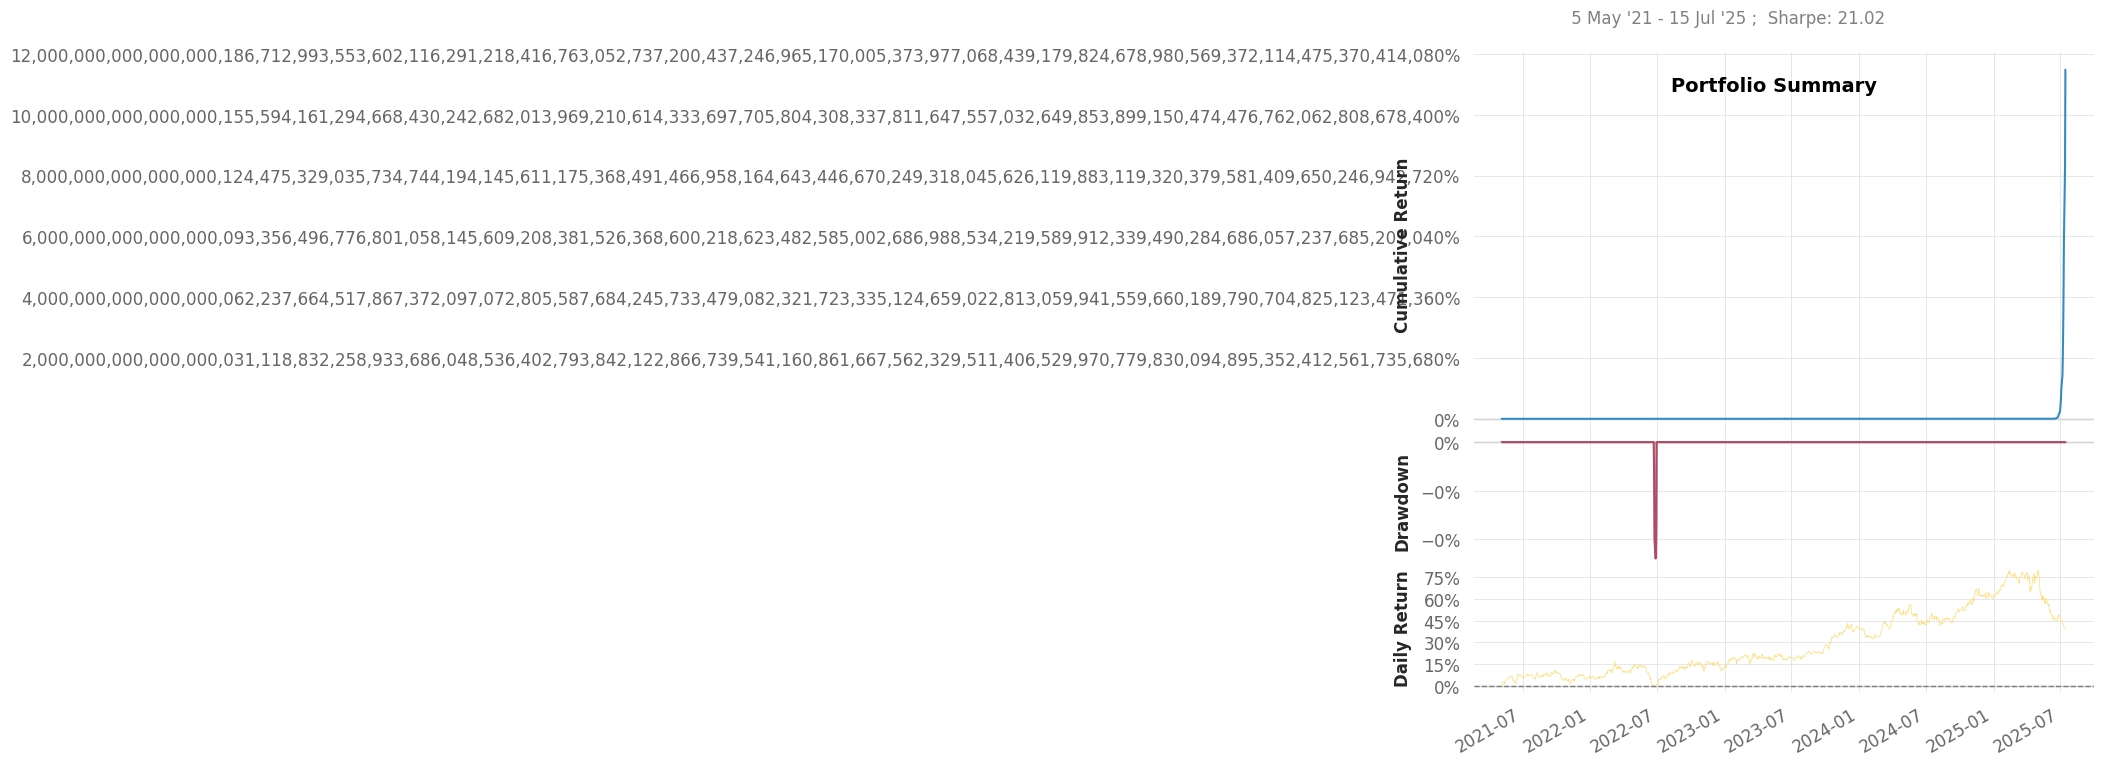

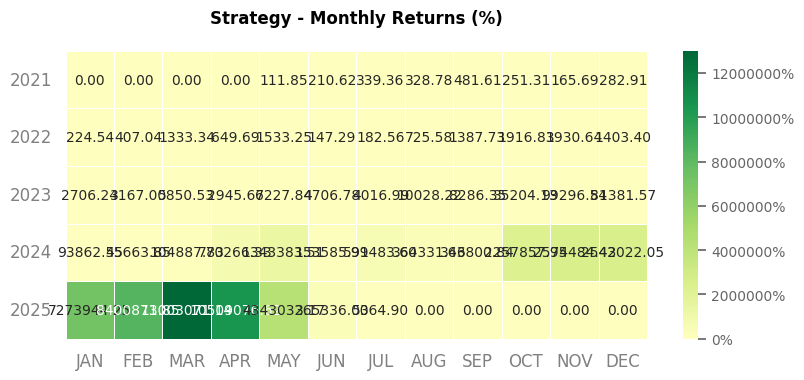

In [34]:
qs.reports.basic(cumulative_strategy_returns, benchmark=cumulative_actual_returns, output='backtest_report.html')